In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from sklearn.preprocessing import LabelEncoder
import regex as re
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict, Text  # Dict 임포트 추가
font_path = "C:/Windows/Fonts/malgun.ttf"
# font = font_manager.FontProperties(fname = font_path).get_name()
# rc('font', family = font)

In [2]:
#pip install tensorflow_recommenders

In [2]:
train1 = pd.read_csv("train.csv")
train=train1.copy()
train.shape

(871393, 10)

In [3]:
display(train.head(3))

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books


In [31]:
import tensorflow as tf
import numpy as np
import pandas as pd
from typing import Dict, Text
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# 데이터 불러오기
train1 = pd.read_csv("train.csv")
train_data=train1.copy()
# scaler = RobustScaler()
# train_data['Book-Rating'] = scaler.fit_transform(train_data['Book-Rating'].values.reshape(-1, 1))
# replace_value = 1  # 0 대신 사용할 값 (1은 임의로 선택한 값)
# train_data['Book-Rating'] = np.log(train_data['Book-Rating'].values.reshape(-1, 1) + replace_value)
#train_data['Book-Rating'] = scaler.fit_transform(train_data['Book-Rating'].values.reshape(-1, 1))
# 필요한 열만 선택
train_data = train_data[["User-ID", "Book-Rating", "Book-Title"]]


# TensorFlow 데이터셋으로 변환
ratings = tf.data.Dataset.from_tensor_slices({
        "book_title": train_data["Book-Title"].values,
        "user_id": train_data["User-ID"].values,
        "book_rating": train_data["Book-Rating"].values
})
# 데이터셋 분할 비율 설정
train_size = int(len(train_data) * 0.8)
test_size = len(train_data) - train_size

# 훈련 및 테스트 세트로 분할
train = ratings.take(train_size)
test = ratings.skip(train_size)

# 도서 제목과 사용자 ID 추출
unique_user_ids = np.unique(train_data["User-ID"].values)
unique_book_titles = np.unique(train_data["Book-Title"].values)

# 정보 출력
print("First 10 unique book titles:", list(unique_book_titles)[:10])
print("Number of unique book titles:", len(unique_book_titles))
print("Number of unique user ids:", len(unique_user_ids))

First 10 unique book titles: [' A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)', ' Always Have Popsicles', " Apple Magic (The Collector's series)", ' Ask Lily (Young Women of Faith: Lily Series, Book 5)', ' Beyond IBM: Leadership Marketing and Finance for the 1990s', ' Clifford Visita El Hospital (Clifford El Gran Perro Colorado)', ' Deceived', ' Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth', ' Final Fantasy Anthology: Official Strategy Guide (Brady Games)', ' Flight of Fancy: American Heiresses (Zebra Ballad Romance)']
Number of unique book titles: 217829
Number of unique user ids: 83256


## TFRS - RetrievalModel

In [16]:
class RetrievalModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    embedding_dimension = 32 # 임베딩 벡터 차원
    # 순차적으로 쌓기 위해(문자열-> 정수인덱스)
    self.user_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_user_ids, mask_token=None), # 모든 토큰 처리
      
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension) # 추가적인 임베딩 생성
    ])

    self.book_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_book_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_book_titles) + 1, embedding_dimension)
    ])

In [17]:
# 추천 책에 대한 임베딩 생성을 위한 데이터 셋 준비
class BookRetrievalModel(tfrs.Model):

  def __init__(self):
    super().__init__()

    self.retrieval_model = RetrievalModel() #북 추천 모델
    self.task = tfrs.tasks.Retrieval(
      metrics = tfrs.metrics.FactorizedTopK(
        candidates = tf.data.Dataset.from_tensor_slices(train_data['Book-Title']).batch(128).map(self.retrieval_model.book_model) # 책 제목을 개별적인 텐서로 나눔
      )
    )
  # loss 값 계산
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor: # 학습모드 여부
    
    user_embeddings = self.retrieval_model.user_model(features["user_id"]) # 사용자 ID에 대한 사용자 임베딩을 추출
    positive_book_embeddings = self.retrieval_model.book_model(features["book_title"]) # 책 제목에 대한 사용자 임베딩을 추출

    return self.task(user_embeddings, positive_book_embeddings)

In [18]:
retrieval_model = BookRetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [19]:
cached_train = train.cache()
cached_test = test.cache()

In [21]:
retrieval_model.fit(cached_train, epochs=3)

Epoch 1/3


     2/697114 [..............................] - ETA: 151:05:43 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - regularization_loss: 0.0000e+00 - total_loss: 0.0000e+00

KeyboardInterrupt: 

## TFRS - Ranking model

In [32]:
class RankingModel(tf.keras.Model):

    def __init__(self, unique_user_ids, unique_book_titles, embedding_dimension=64):
        super().__init__()

        
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

       
        self.book_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_book_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_book_titles) + 1, embedding_dimension)
        ])

        # predictions
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):
        user_id, book_title = inputs

        user_embedding = self.user_embeddings(user_id)
        book_embedding = self.book_embeddings(book_title)

        return self.ratings(tf.concat([user_embedding, book_embedding], axis=1)) # 최종 평점 예측


class BookRankingModel(tfrs.models.Model):
    # 노션 참조
    def __init__(self, unique_user_ids, unique_book_titles):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel(unique_user_ids, unique_book_titles)
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking( # 평점 예측을 위한 작업, 순위 예측
            loss=tf.keras.losses.MeanSquaredError(), 
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    # 입력 데이터를 받아서 해당하는 평점을 예측하는 데 사용
    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_id"], features["book_title"])) #사용자 ID , 책 제목에 해당하는 텐서

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor: # 훈련되는 타겟
        labels = features.pop("book_rating") # 딕셔너리에서 해당 키에 대한 값을 추출하고 제거

        rating_predictions = self(features)

        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)


# BookRankingModel 클래스 초기화
ranking_model = BookRankingModel(unique_user_ids, unique_book_titles)
ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

cached_train = train.batch(4096).cache()
cached_test = test.batch(4096).cache()

# 모델 훈련
ranking_model.fit(cached_train , epochs=15)

# 모델 평가
ranking_model.evaluate(cached_test)

Epoch 1/15
171/171 [==============================] - 2s 6ms/step - root_mean_squared_error: 3.9483 - loss: 15.5702 - regularization_loss: 0.0000e+00 - total_loss: 15.5702
Epoch 2/15
171/171 [==============================] - 1s 5ms/step - root_mean_squared_error: 3.8261 - loss: 14.6274 - regularization_loss: 0.0000e+00 - total_loss: 14.6274
Epoch 3/15
171/171 [==============================] - 1s 5ms/step - root_mean_squared_error: 3.7338 - loss: 13.9267 - regularization_loss: 0.0000e+00 - total_loss: 13.9267
Epoch 4/15
171/171 [==============================] - 1s 5ms/step - root_mean_squared_error: 3.5878 - loss: 12.8575 - regularization_loss: 0.0000e+00 - total_loss: 12.8575
Epoch 5/15
171/171 [==============================] - 1s 6ms/step - root_mean_squared_error: 3.4833 - loss: 12.1221 - regularization_loss: 0.0000e+00 - total_loss: 12.1221
Epoch 6/15
171/171 [==============================] - 1s 6ms/step - root_mean_squared_error: 3.4234 - loss: 11.7093 - regularization_loss: 0

[4.129166603088379, 16.83509063720703, 0, 16.83509063720703]

43/43 [==============================] - 0s 2ms/step


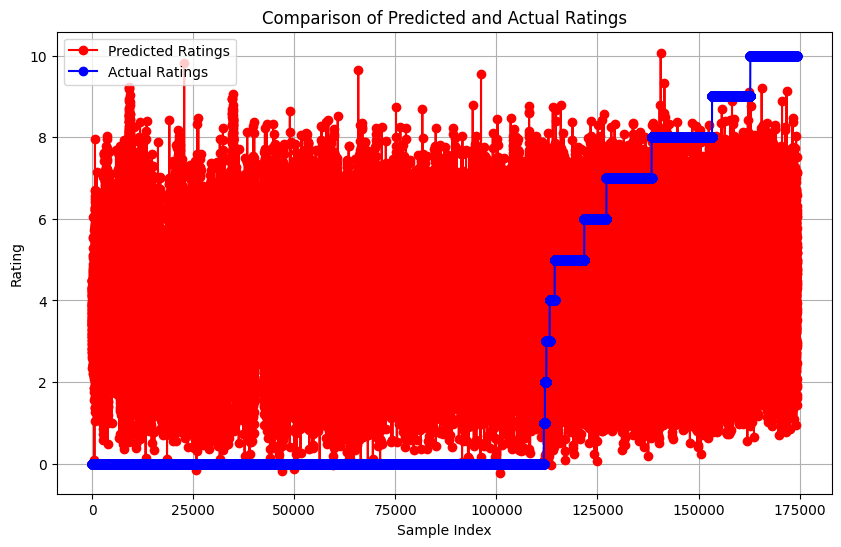

In [30]:
import matplotlib.pyplot as plt

# 테스트 데이터셋에서 예측 평점 및 실제 평점 가져오기
predicted_ratings = ranking_model.predict(cached_test)
actual_ratings = np.concatenate([sample["book_rating"].numpy() for sample in cached_test])

# 인덱스에 따라 예측된 평점 및 실제 평점 정렬
sorted_indices = np.argsort(actual_ratings)
predicted_ratings = predicted_ratings[sorted_indices]
actual_ratings = actual_ratings[sorted_indices]

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_ratings, 'ro-', label='Predicted Ratings')
plt.plot(actual_ratings, 'bo-', label='Actual Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.title('Comparison of Predicted and Actual Ratings')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import pandas as pd

# 테스트 데이터셋에서 예측 평점 및 실제 평점 가져오기
predicted_ratings = ranking_model.predict(cached_test).flatten()
actual_ratings = np.concatenate([sample["book_rating"].numpy() for sample in cached_test])

# 데이터프레임 생성
result = pd.DataFrame({'predict_rating': predicted_ratings, 'actual_ranking': actual_ratings})

# 결과 출력
print(result)


 1/43 [..............................] - ETA: 0s

43/43 [==============================] - 0s 2ms/step
        predict_rating  actual_ranking
0             3.669989               8
1             6.215564               0
2             4.296581               0
3             3.758794               9
4             3.379745               0
...                ...             ...
174274        2.120280               0
174275        3.922281               0
174276        5.981252               0
174277        4.105840               8
174278        2.722058               0

[174279 rows x 2 columns]


In [32]:
user_rand_index = np.where(unique_user_ids == 'USER_00000')[0][0]
test_ratings = {}
# 테스트 데이터셋에서 상위 5개 도서를 추천
for sample in test.take(5):
    user_id = tf.convert_to_tensor([str(unique_user_ids[user_rand_index])])
    book_title = tf.convert_to_tensor([sample["book_title"].numpy().decode()])
    rating = RankingModel(unique_user_ids, unique_book_titles)((user_id, book_title))
    test_ratings[sample["book_title"].numpy()] = rating.numpy()[0][0]

print("사용자 {}를 위한 상위 5개 권장 제품: ".format(unique_user_ids[user_rand_index]))
for title in sorted(test_ratings, key=test_ratings.get, reverse=True):
    print(title)


사용자 USER_00000를 위한 상위 5개 권장 제품: 
b'The Lion, the Witch and the Wardrobe (rpkg) (Narnia)'
b'The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)'
b'Love That Dog'
b'Danger Along the Ohio (An Avon Camelot Book)'
b'Matilda'


In [34]:
result = pd.DataFrame()
predictions = ranking_model.predict(cached_test)

result['predicted_rating'] = predictions.flatten()
real_ratings = np.concatenate([batch["book_rating"].numpy() for batch in cached_test])
result["predicted_rating_ranking"] = result['predicted_rating'].rank(ascending=False, method="dense").astype(int)
result["real_rating_ranking"] = pd.Series(real_ratings).rank(ascending=False, method="first").astype(int)
print(result)


 1/43 [..............................] - ETA: 0s

43/43 [==============================] - 0s 3ms/step
        predicted_rating  predicted_rating_ranking  real_rating_ranking
0               4.202373                     77294                20954
1               5.742534                     16217                62561
2               4.261225                     73951                62562
3               3.589988                    112552                11494
4               4.214155                     76644                62563
...                  ...                       ...                  ...
174274          2.717451                    150403               174276
174275          5.124881                     34152               174277
174276          7.371077                       535               174278
174277          4.498498                     61511                35890
174278          3.088097                    137105               174279

[174279 rows x 3 columns]


# 실험

In [25]:
import tensorflow as tf
import tensorflow_recommenders as tfrs

class RankingModel(tfrs.Model):
    def __init__(self, unique_user_ids, unique_book_titles, embedding_dimension=16):
        super().__init__()
        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        # Compute embeddings for books.
        self.book_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_book_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_book_titles) + 1, embedding_dimension)
        ])
        # Compute predictions.
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    def call(self, features):
        user_id, book_title = features['user_id'], features['book_title']
        user_embedding = self.user_embeddings(user_id)
        book_embedding = self.book_embeddings(book_title)
        return user_embedding, book_embedding
    def compute_loss(self, features, training=False):
        user_embedding, book_embedding = self(features)
        rating_predictions = tf.keras.layers.Dot(axes=1)([user_embedding, book_embedding])
        loss = self.task(features["book_rating"], rating_predictions)
        return loss

# Model instantiation
model = RankingModel(unique_user_ids, unique_book_titles)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001))

# Fit the model
model.fit(cached_train, epochs=10) 

# Evaluate the model
model.evaluate(cached_test) 
30

Epoch 1/10
697114/697114 [==============================] - 444s 636us/step - root_mean_squared_error: 4.7907 - loss: 22.9504 - regularization_loss: 0.0000e+00 - total_loss: 22.9504
Epoch 2/10
697114/697114 [==============================] - 448s 643us/step - root_mean_squared_error: 4.7906 - loss: 22.9481 - regularization_loss: 0.0000e+00 - total_loss: 22.9481
Epoch 3/10
697114/697114 [==============================] - 450s 646us/step - root_mean_squared_error: 4.7906 - loss: 22.9467 - regularization_loss: 0.0000e+00 - total_loss: 22.9467
Epoch 4/10
697114/697114 [==============================] - 445s 638us/step - root_mean_squared_error: 4.7906 - loss: 22.9454 - regularization_loss: 0.0000e+00 - total_loss: 22.9454
Epoch 5/10
697114/697114 [==============================] - 445s 639us/step - root_mean_squared_error: 4.7905 - loss: 22.9443 - regularization_loss: 0.0000e+00 - total_loss: 22.9443
Epoch 6/10
697114/697114 [==============================] - 437s 627us/step - root_mean_sq

30

In [ ]:
result = pd.DataFrame(data={"book_title": titles[0], "score": scores[0]})


# 추천결과의 rating을 예측해서 저장함
retrieved_book_titles = result.book_title.tolist()
result["predicted_rating"] = ranking_model.ranking_model((
    tf.constant([user_id] * len(retrieved_movie_titles)),
    tf.constant(retrieved_book_titles)
    )).numpy()

# Ranking Model로 예측된 rating으로 랭킹을 매겨본다.
result["predicted_rating_ranking"] = result.predicted_rating.rank(ascending=False).astype(int)

In [30]:
result = pd.DataFrame()
predictions, _ = model.predict(cached_test)
if len(predictions.shape) > 1:
    predictions = predictions.flatten()
result['predicted_rating'] = predictions

result["predicted_rating_ranking"] = result['predicted_rating'].rank(ascending=False, method="dense").astype(int)
print(result)


174279/174279 [==============================] - 102s 583us/step
         predicted_rating  predicted_rating_ranking
0                0.011934                    104571
1                0.050268                         1
2                0.011822                    104846
3               -0.000362                    138173
4               -0.019843                    191844
...                   ...                       ...
2788459         -0.024621                    205052
2788460          0.039505                     28789
2788461         -0.049945                    274843
2788462         -0.022569                    199382
2788463         -0.041964                    252961

[2788464 rows x 2 columns]
